In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score

In [4]:
sqlobject=sqlite3.connect(r"C:\Users\Sanu\Desktop\sana.ml\amazon dataset\database1.sqlite")  
reviews = pd.read_sql_query("""SELECT Score, Summary FROM Reviews""", sqlobject)

In [5]:
original = reviews.copy()

In [6]:
reviews = original.copy()

In [7]:
print(reviews.shape)

(568454, 2)


In [8]:
reviews = reviews.dropna()


In [9]:
print (reviews.shape)


(568454, 2)


In [10]:
print (reviews.head(25))

    Score                                            Summary
0       5                              Good Quality Dog Food
1       1                                  Not as Advertised
2       4                              "Delight" says it all
3       2                                     Cough Medicine
4       5                                        Great taffy
5       4                                         Nice Taffy
6       5      Great!  Just as good as the expensive brands!
7       5                             Wonderful, tasty taffy
8       5                                         Yay Barley
9       5                                   Healthy Dog Food
10      5                    The Best Hot Sauce in the World
11      5  My cats LOVE this "diet" food better than thei...
12      1               My Cats Are Not Fans of the New Food
13      4                                  fresh and greasy!
14      5                       Strawberry Twizzlers - Yummy
15      5           Lots

Encoding score to Positive or negative based on value of each sample

In [11]:
scores = reviews['Score']
reviews['Score'] = reviews['Score'].apply(lambda x : 'pos' if x > 3 else 'neg')

In [12]:
scores.mean()

4.183198640523243

Distribution of labels in the dataset

In [13]:
reviews.groupby('Score')['Summary'].count()

Score
neg    124677
pos    443777
Name: Summary, dtype: int64

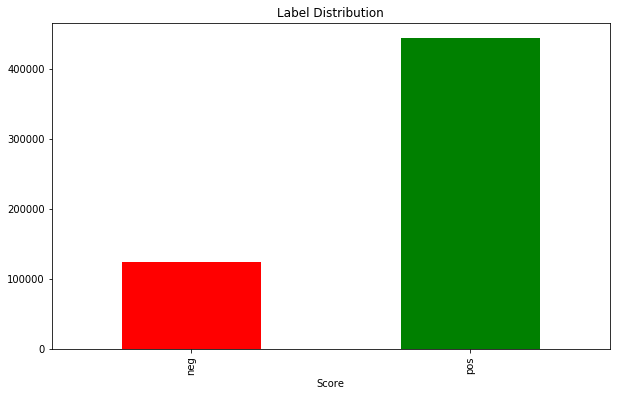

In [14]:
reviews.groupby('Score')['Summary'].count().plot(kind='bar',color=['r','g'],title='Label Distribution',figsize=(10,6))

In [15]:
print ('Percentage of negative reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()['neg'])*100.0/len(reviews)))
print ('Percentage of positive reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()['pos'])*100.0/len(reviews)))

Percentage of negative reviews 21.93 %
Percentage of positive reviews 78.07 %


Splitting the dataset based on labels

In [16]:
def splitPosNeg(Summaries):
    neg = reviews.loc[Summaries['Score']=='neg']
    pos = reviews.loc[Summaries['Score']=='pos']
    return [pos,neg]

In [17]:
[pos,neg] = splitPosNeg(reviews)

Preprocessing

Using lemmatization as it was giving better results than stemming. 
Other steps include removing punctuation amd upper case to lower case conversion.

In [22]:
#preprocessing steps

#stemmer = PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()
stop = stopwords.words('english')
translation = str.maketrans(string.punctuation,' '*len(string.punctuation))

def preprocessing(line):
    tokens=[]
    line = line.translate(translation)
    line = nltk.word_tokenize(line.lower())
    for t in line:
        #if(t not in stop):
            #stemmed = stemmer.stem(t)
        stemmed = lemmatizer.lemmatize(t)
        tokens.append(stemmed)
    return ' '.join(tokens)

In [20]:
import nltk
nltk.download('stopword')


[nltk_data] Error loading stopword: Package 'stopword' not found in
[nltk_data]     index


False

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sanu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [29]:
pos_data = []
neg_data = []
for p in pos['Summary']:
    pos_data.append(preprocessing(p))

for n in neg['Summary']:
    neg_data.append(preprocessing(n))

In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sanu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [31]:
import nltk
nltk.download('wordnet')
  

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sanu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
data = pos_data + neg_data
labels = np.concatenate((pos['Score'].values,neg['Score'].values))

Splitting the data into train and test using a stratified strategy

In [32]:
[Data_train,Data_test,Train_labels,Test_labels] = train_test_split(data,labels , test_size=0.25, random_state=20160121,stratify=labels)

In [33]:
t = []
for line in Data_train:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)

In [34]:
word_features = nltk.FreqDist(t)
print (len(word_features))

27048


We would want to reduce the size of this feature set.
This can be done in severals ways.
One of them is feature reduction using PCA.

 Feature Reduction

a. Using PCA

In [35]:
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [36]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [37]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

Pca doesn't apply to sparse matrices so we use a different version of PCA called Truncated SVD

In [38]:
svd = TruncatedSVD(n_components=200)
tr_features_truncated = svd.fit_transform(tr_features_all)

In [39]:
te_features_truncated = svd.transform(te_features_all)


In [40]:
svd = TruncatedSVD(n_components=200)
ctr_features_truncated = svd.fit_transform(ctr_features_all)
cte_features_truncated = svd.transform(cte_features_all)

Running 4 classification algorithms : Naive Bayes, Logistic Regression, Decision Trees and Perceptron

In [41]:
models = {'BernoulliNB':BernoulliNB(binarize=0.5)
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy'),
                                                                                                        'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [49]:
results_svd = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        model.fit(tr_features_truncated, Train_labels)
        tfprediction[name] = model.predict(te_features_truncated)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_truncated,Train_labels)
        #cprediction[name] = model.predict(cte_features_truncated)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)

        results_svd.loc[foldnum,'Model']=name
        results_svd.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_svd.loc[foldnum,'Count Accuracy']=caccuracy
        foldnum = foldnum+1
print (results_svd)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


           Model  TF-IDF Accuracy
0    BernoulliNB         0.793412
1       Logistic         0.844991
2  Decision Tree         0.856031
3     Perceptron         0.811335


In [50]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.90      0.07      0.12     31169
        pos       0.79      1.00      0.88    110945

avg / total       0.81      0.79      0.72    142114



Classification report for  Logistic
             precision    recall  f1-score   support

        neg       0.77      0.42      0.54     31169
        pos       0.86      0.96      0.91    110945

avg / total       0.84      0.84      0.83    142114



Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.67      0.68      0.68     31169
        pos       0.91      0.90      0.91    110945

avg / total       0.86      0.86      0.86    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.56      0.61      0.59     31169
        pos       0.89      0.87      0.88    110945

avg / total       0.82      0.81  

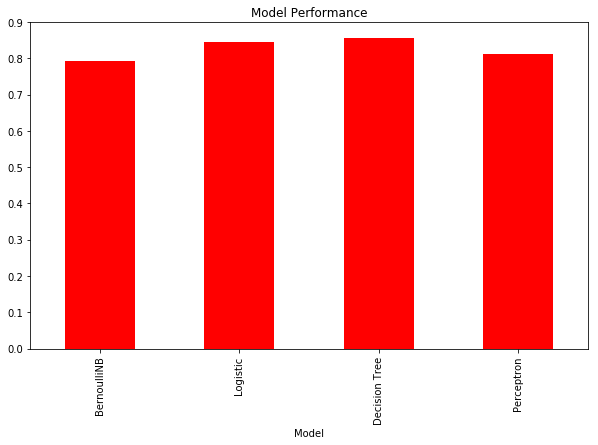

In [51]:
results_svd.plot(kind='bar',color=['r','g','b','y'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [52]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

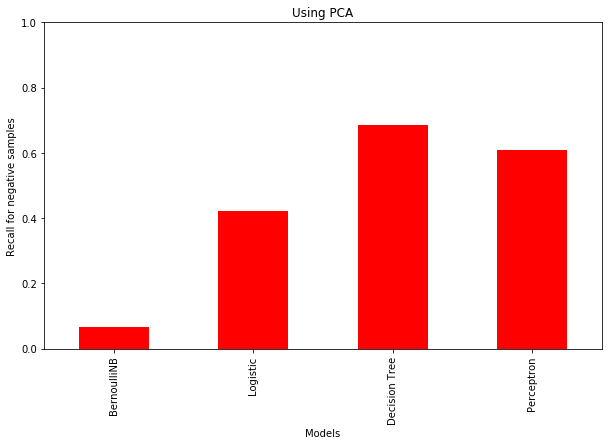

In [53]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Using PCA',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

Another way to reduce feature set is to have better feature selection. We can use the most frequent 5000 features as the featureset

Feature Selection

In [54]:
topwords = [fpair[0] for fpair in list(word_features.most_common(5000))]

In [55]:
print (word_features.most_common(25))


[('great', 55078), ('the', 41540), ('good', 38876), ('a', 38079), ('for', 30448), ('love', 26982), ('and', 26492), ('not', 25274), ('it', 25120), ('best', 25075), ('my', 21948), ('coffee', 19082), ('i', 19041), ('but', 18943), ('this', 18389), ('taste', 18227), ('tea', 17046), ('to', 15942), ('dog', 15760), ('product', 15523), ('of', 15457), ('is', 14242), ('delicious', 14189), ('s', 13046), ('very', 11988)]


In [56]:
word_his = pd.DataFrame(word_features.most_common(25),columns=['words','count'])

In [57]:
print (word_his)

        words  count
0       great  55078
1         the  41540
2        good  38876
3           a  38079
4         for  30448
5        love  26982
6         and  26492
7         not  25274
8          it  25120
9        best  25075
10         my  21948
11     coffee  19082
12          i  19041
13        but  18943
14       this  18389
15      taste  18227
16        tea  17046
17         to  15942
18        dog  15760
19    product  15523
20         of  15457
21         is  14242
22  delicious  14189
23          s  13046
24       very  11988


In [68]:
word_his.plot(kind='bar',x=word_his['words'],legend=False,title='Top 20 most freq words',figsize=(10,6))

KeyError: "['great' 'the' 'good' 'a' 'for' 'love' 'and' 'not' 'it' 'best' 'my'\n 'coffee' 'i' 'but' 'this' 'taste' 'tea' 'to' 'dog' 'product' 'of' 'is'\n 'delicious' 's' 'very'] not in index"

In [66]:
reviews.columns =reviews.columns.str.strip()

In [69]:
vec = CountVectorizer()
c_fit = vec.fit_transform([' '.join(topwords)])

In [70]:
tf_vec = TfidfTransformer()
tf_fit = tf_vec.fit_transform(c_fit)

In [71]:
ctr_features = vec.transform(Data_train)
tr_features = tf_vec.transform(ctr_features)

In [72]:
cte_features = vec.transform(Data_test)
te_features = tf_vec.transform(cte_features)

In [73]:
models = {'BernoulliNB':BernoulliNB()
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy'),
          'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [74]:
results = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        
        model.fit(tr_features, Train_labels)
        tfprediction[name] = model.predict(te_features)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features,Train_labels)
        #cprediction[name] = model.predict(cte_features)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results.loc[foldnum,'Count Accuracy']=caccuracy
        results.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy          Model
0         0.869105    BernoulliNB
1         0.888808       Logistic
2         0.914723  Decision Tree
3         0.852316     Perceptron


In [75]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.72      0.67      0.69     31169
        pos       0.91      0.93      0.92    110945

avg / total       0.87      0.87      0.87    142114



Classification report for  Logistic
             precision    recall  f1-score   support

        neg       0.80      0.66      0.72     31169
        pos       0.91      0.95      0.93    110945

avg / total       0.88      0.89      0.88    142114



Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.82      0.78      0.80     31169
        pos       0.94      0.95      0.95    110945

avg / total       0.91      0.91      0.91    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.70      0.57      0.63     31169
        pos       0.89      0.93      0.91    110945

avg / total       0.84      0.85  

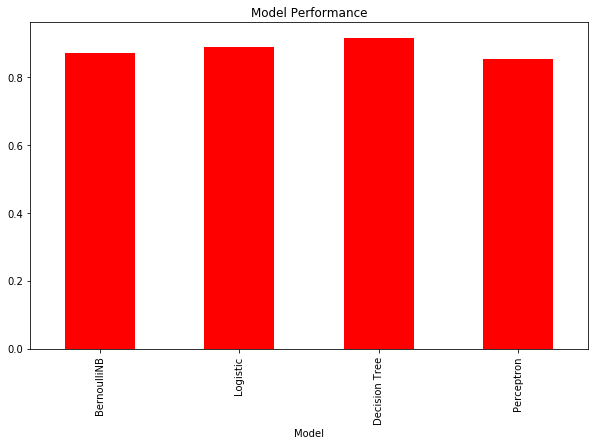

In [76]:
results.plot(kind='bar',color=['r','g','b','y'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [77]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

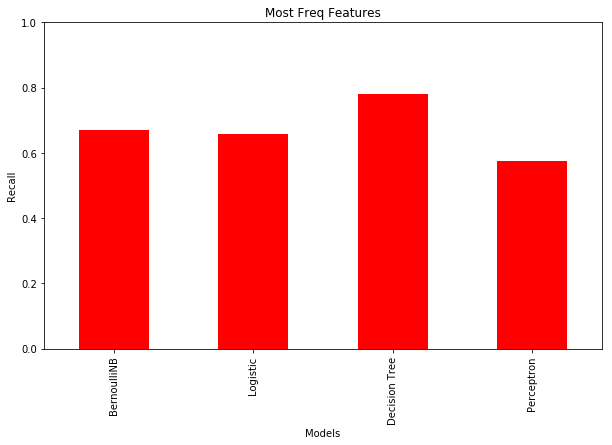

In [78]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Most Freq Features',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall')
lim = plt.ylim([0,1])

 Finally we can try by running it on our entire featureset.
One can guess it will take a lot of time with Decision Tree Classifier.
We can make use of group of words to get better results. 
Sometimes sequence of words might have different effect on the prediction. 
Sequences like "not good" or "not bad" affect the prediction in way different than when used individually.

a. Unigram

In [79]:
### using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [80]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [81]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [82]:
models = {'BernoulliNB':BernoulliNB()
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [83]:
results_all_uni = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_uni.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_uni.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_uni.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_uni)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy        Model
0         0.873644  BernoulliNB
1         0.893346     Logistic
2         0.861090   Perceptron


In [84]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.73      0.68      0.70     31169
        pos       0.91      0.93      0.92    110945

avg / total       0.87      0.87      0.87    142114

Classification report for  Logistic
             precision    recall  f1-score   support

        neg       0.80      0.69      0.74     31169
        pos       0.92      0.95      0.93    110945

avg / total       0.89      0.89      0.89    142114

Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.70      0.64      0.67     31169
        pos       0.90      0.92      0.91    110945

avg / total       0.86      0.86      0.86    142114



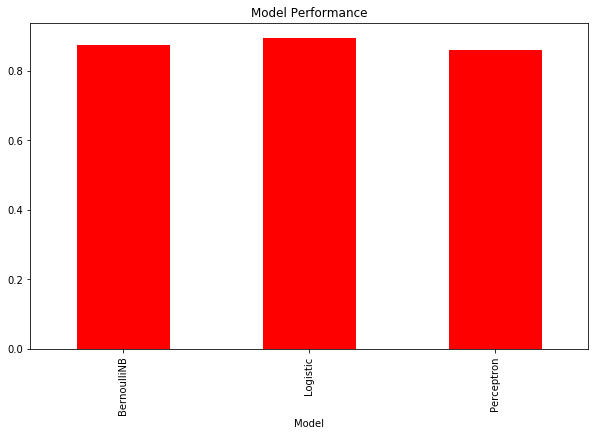

In [85]:
results_all_uni.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [86]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

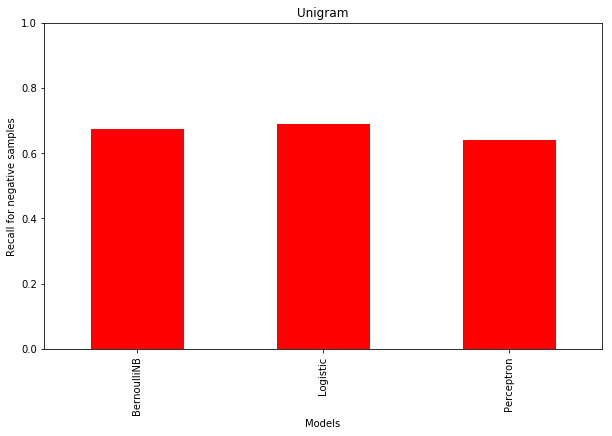

In [87]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Unigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

b. Using Bigrams

In [88]:
## using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer(ngram_range=(1,2))
ctr_features_all = vec_all.fit_transform(Data_train)

In [89]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)


In [90]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [91]:
print ((ctr_features_all.shape))

(426340, 263567)


In [92]:
results_all_bi = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)
tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_bi.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_bi.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_bi.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_bi)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy        Model
0         0.887231  BernoulliNB
1         0.928550     Logistic
2         0.903760   Perceptron


In [93]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.79      0.67      0.72     31169
        pos       0.91      0.95      0.93    110945

avg / total       0.88      0.89      0.88    142114



Classification report for  Logistic
             precision    recall  f1-score   support

        neg       0.86      0.80      0.83     31169
        pos       0.95      0.96      0.95    110945

avg / total       0.93      0.93      0.93    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.78      0.78      0.78     31169
        pos       0.94      0.94      0.94    110945

avg / total       0.90      0.90      0.90    142114





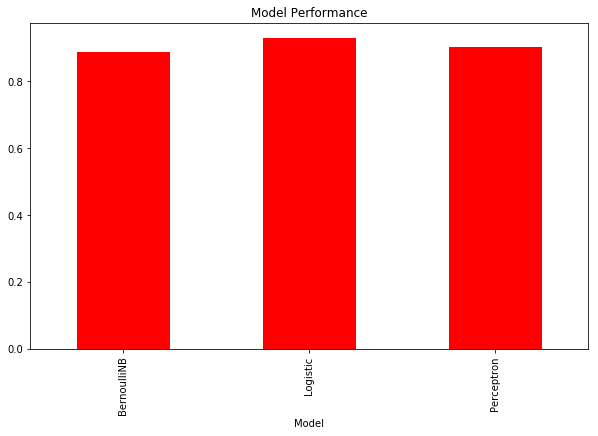

In [94]:
results_all_bi.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [95]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

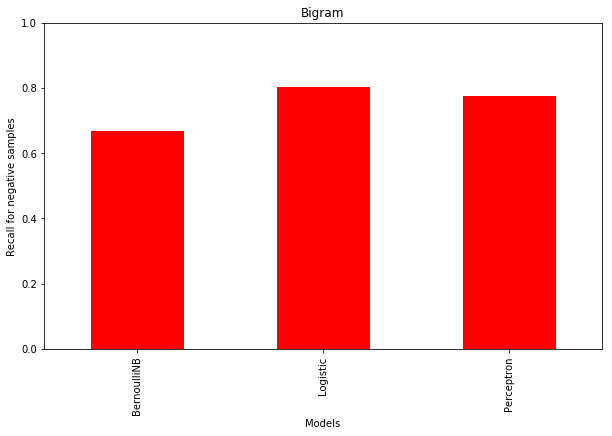

In [96]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Bigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

c. Using Trigrams

In [97]:
## using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer(ngram_range=(1,3))
ctr_features_all = vec_all.fit_transform(Data_train)

In [98]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)


In [99]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [100]:
results_all_tri = pd.DataFrame()

#stratified = StratifiedKFold(labels, n_folds=5,random_state=20160121, shuffle=True)
tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_all,Train_labels)
        #cprediction[name] = model.predict(cte_features_all)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results_all_tri.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_all_tri.loc[foldnum,'Count Accuracy']=caccuracy
        results_all_tri.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_tri)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy        Model
0         0.870041  BernoulliNB
1         0.932287     Logistic
2         0.919227   Perceptron


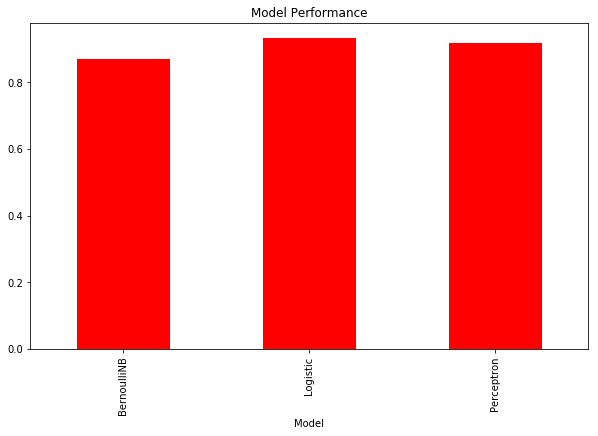

In [101]:
results_all_tri.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [102]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

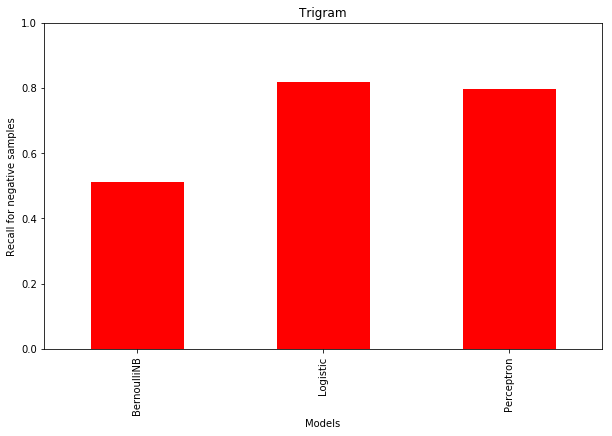

In [103]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Trigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

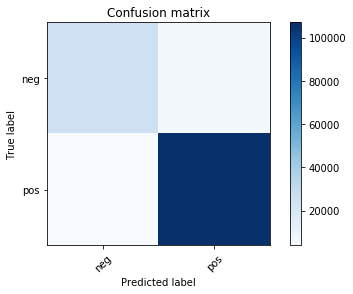

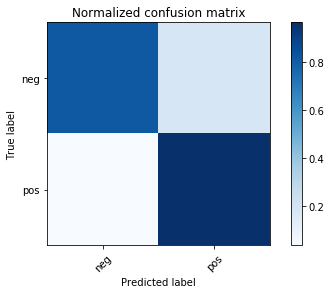

In [104]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(labels)))
    plt.xticks(tick_marks, ['neg','pos'], rotation=45)
    plt.yticks(tick_marks, ['neg','pos'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(Test_labels, tfprediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()